In [1]:
!pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.6 MB/s eta 0:00:00


In [2]:
from pydriller import Repository

In [3]:
#choosing python, stars>25000, forks>5000, commits>1000, contributors>10: got 81 repos

repo_1= 'https://github.com/facebookresearch/detectron2'
repo_2='https://github.com/All-Hands-AI/OpenHands'
repo_3='https://github.com/home-assistant/core'

In [4]:
!git clone https://github.com/facebookresearch/detectron2
!git clone https://github.com/All-Hands-AI/OpenHands
!git clone https://github.com/home-assistant/core

Cloning into 'detectron2'...
remote: Enumerating objects: 15912, done.
remote: Total 15912 (delta 0), reused 0 (delta 0), pack-reused 15912 (from 1)
Receiving objects: 100% (15912/15912), 6.67 MiB | 7.10 MiB/s, done.
Resolving deltas: 100% (11332/11332), done.
Cloning into 'OpenHands'...
remote: Enumerating objects: 120904, done.
remote: Counting objects: 100% (1261/1261), done.
remote: Compressing objects: 100% (677/677), done.
remote: Total 120904 (delta 962), reused 603 (delta 583), pack-reused 119643 (from 4)
Receiving objects: 100% (120904/120904), 230.13 MiB | 28.01 MiB/s, done.
Resolving deltas: 100% (88788/88788), done.
Cloning into 'core'...
remote: Enumerating objects: 1153780, done.
remote: Counting objects: 100% (472/472), done.
remote: Compressing objects: 100% (258/258), done.
remote: Total 1153780 (delta 403), reused 214 (delta 214), pack-reused 1153308 (from 5)
Receiving objects: 100% (1153780/1153780), 722.58 MiB | 18.21 MiB/s, done.
Resolving deltas: 100% (823243/8232

In [5]:
from git import Repo
r1 = Repo("OpenHands")
all_commits_1 = list(r1.iter_commits())

r2 = Repo("core")
all_commits_2 = list(r2.iter_commits())

r3 = Repo("detectron2")
all_commits_3 = list(r3.iter_commits())

In [6]:
%cd  /content/detectron2
!git log

Streaming output truncated to the last 5000 lines.
    Summary:
    it can also close https://github.com/facebookresearch/detectron2/issues/949
    Pull Request resolved: https://github.com/fairinternal/detectron2/pull/390
    
    Reviewed By: rbgirshick
    
    Differential Revision: D20187249
    
    Pulled By: ppwwyyxx
    
    fbshipit-source-id: 37099e9072133237a721fc473c6e66d1fa6c883e

commit 33e022db2c988ae15c65d9e409711d1693b917d5
Author: Yuxin Wu <yuxinwu@fb.com>
Date:   Fri Feb 28 18:26:28 2020 -0800

    update lvis path
    
    Reviewed By: alexander-kirillov
    
    Differential Revision: D20175610
    
    fbshipit-source-id: 7f31e934efd6aa703e2f40c30ee9546c5e88bc61

commit f101a0c0c6958cc28c70eb82afc95588f7bebe9d
Author: Yuxin Wu <ppwwyyxxc@gmail.com>
Date:   Fri Feb 28 07:40:26 2020 -0800

    fix rpn evaluation when no predictions are made (#388)
    
    Summary:
    fix https://github.com/facebookresearch/detectron2/issues/952
    Pull Request resolved: https://

In [9]:
import csv
import subprocess
import re
import pandas as pd
from pydriller import Repository


REPO_PATH1 = "/content/detectron2"
REPO_PATH2 = "/content/OpenHands"
REPO_PATH3 = "/content/core"
OUTPUT_CSV_1 = "/content/repo_diffs_detectron.csv"
OUTPUT_CSV_2 = "/content/repo_diffs_openhands.csv"
OUTPUT_CSV_3 = "/content/repo_diffs_homeassistant.csv"

def git_diff(repo_path, parent_sha, commit_sha, file_path, algo):
  cmd = [
      "git", "-C", repo_path, "diff",
      "--diff-algorithm=" + algo,
      "-b", "--ignore-blank-lines",
      parent_sha, commit_sha, "--", file_path
      ]
  try:
    out = subprocess.check_output(cmd, text=True)
    return out
  except:
    return ""


def normalize_diff(diff_text):
  lines = []
  for ln in diff_text.splitlines():
    if ln.startswith(("index ", "--- ", "+++ ", "@@")):
      continue
    s = re.sub(r"\s+", " ", ln.strip())
    if s != "":
      lines.append(s)
  return "\n".join(lines)


In [10]:
with open(OUTPUT_CSV_1, "w", newline="", encoding="utf-8") as f:
  writer = csv.writer(f)
  writer.writerow([
      "old_file", "new_file", "commit_sha", "parent_commit_sha",
      "commit_message", "diff_myers", "diff_histogram", "discrepancy"
  ])

  for commit in Repository(REPO_PATH1, only_no_merge=True).traverse_commits():
    if not commit.parents:
      continue
    parent_sha = commit.parents[0]

    for m in commit.modified_files:
      diff_preview = m.diff or ""
      if "Binary files" in diff_preview:
        continue

      old_path = m.old_path or ""
      new_path = m.new_path or ""
      file_path = new_path if new_path else old_path

      diff_myers = git_diff(REPO_PATH1, parent_sha, commit.hash, file_path, "myers")
      diff_hist  = git_diff(REPO_PATH1, parent_sha, commit.hash, file_path, "histogram")

      norm_myers = normalize_diff(diff_myers)
      norm_hist  = normalize_diff(diff_hist)

      discrepancy = "No" if norm_myers == norm_hist else "Yes"
      writer.writerow([
          old_path, new_path, commit.hash, parent_sha,
          commit.msg.strip(), diff_myers, diff_hist, discrepancy
          ])


with open(OUTPUT_CSV_2, "w", newline="", encoding="utf-8") as f:
  writer = csv.writer(f)
  writer.writerow([
      "old_file", "new_file", "commit_sha", "parent_commit_sha",
      "commit_message", "diff_myers", "diff_histogram", "discrepancy"
  ])

  for commit in Repository(REPO_PATH2, only_no_merge=True).traverse_commits():
    if not commit.parents:
      continue
    parent_sha = commit.parents[0]

    for m in commit.modified_files:
      diff_preview = m.diff or ""
      if "Binary files" in diff_preview:
        continue

      old_path = m.old_path or ""
      new_path = m.new_path or ""
      file_path = new_path if new_path else old_path

      diff_myers = git_diff(REPO_PATH2, parent_sha, commit.hash, file_path, "myers")
      diff_hist  = git_diff(REPO_PATH2, parent_sha, commit.hash, file_path, "histogram")

      norm_myers = normalize_diff(diff_myers)
      norm_hist  = normalize_diff(diff_hist)

      discrepancy = "No" if norm_myers == norm_hist else "Yes"
      writer.writerow([
          old_path, new_path, commit.hash, parent_sha,
          commit.msg.strip(), diff_myers, diff_hist, discrepancy
          ])


with open(OUTPUT_CSV_3, "w", newline="", encoding="utf-8") as f:
  writer = csv.writer(f)
  writer.writerow([
      "old_file", "new_file", "commit_sha", "parent_commit_sha",
      "commit_message", "diff_myers", "diff_histogram", "discrepancy"
  ])

  for commit in Repository(REPO_PATH3, only_no_merge=True).traverse_commits():
    if not commit.parents:
      continue
    parent_sha = commit.parents[0]

    for m in commit.modified_files:
      diff_preview = m.diff or ""
      if "Binary files" in diff_preview:
        continue

      old_path = m.old_path or ""
      new_path = m.new_path or ""
      file_path = new_path if new_path else old_path

      diff_myers = git_diff(REPO_PATH3, parent_sha, commit.hash, file_path, "myers")
      diff_hist  = git_diff(REPO_PATH3, parent_sha, commit.hash, file_path, "histogram")

      norm_myers = normalize_diff(diff_myers)
      norm_hist  = normalize_diff(diff_hist)

      discrepancy = "No" if norm_myers == norm_hist else "Yes"
      writer.writerow([
          old_path, new_path, commit.hash, parent_sha,
          commit.msg.strip(), diff_myers, diff_hist, discrepancy
          ])


In [25]:
CSV_1 = "/content/repo_diffs_detectron.csv"
CSV_2 = "/content/repo_diffs_openhands.csv"
CSV_3 = "/content/repo_diffs_homeassistant.csv"

df1 = pd.read_csv(CSV_1)
df2 = pd.read_csv(CSV_2)
df3 = pd.read_csv(CSV_3)

for df in [df1, df2, df3]:
  if 'discrepancy' in df.columns:
    df.drop(columns=['discrepancy'], inplace=True)

df1.to_csv("deterctron_just_diffs.csv", index=False)
df2.to_csv("openhands_just_diffs.csv", index=False)
df3.to_csv("homeassistant_just_diffs.csv", index=False)

In [11]:
import os
os.listdir("/content")

['.config',
 'repo_diffs_homeassistant.csv',
 'repo_diffs_detectron.csv',
 'detectron2',
 'repo_diffs_openhands.csv',
 'OpenHands',
 'core',
 'sample_data']

In [19]:
df = pd.read_csv("/content/repo_diffs_detectron.csv")
df.head()

,old_file,new_file,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_histogram,discrepancy
0,projects/TridentNet/README.md,projects/TridentNet/README.md,cb68099a6f0bbc67c4a35c674dccda8c43264b24,989f52d67d05445ccd030d8f13d6cc53e297fb91,add results on TridentNet's readme\n\nReviewed...,diff --git a/projects/TridentNet/README.md b/p...,diff --git a/projects/TridentNet/README.md b/p...,No
1,GETTING_STARTED.md,GETTING_STARTED.md,f66d8076c560dfe140abc952d91d0ec63f061b55,cb68099a6f0bbc67c4a35c674dccda8c43264b24,update colab link\n\nReviewed By: rbgirshick\n...,diff --git a/GETTING_STARTED.md b/GETTING_STAR...,diff --git a/GETTING_STARTED.md b/GETTING_STAR...,No
2,INSTALL.md,INSTALL.md,f66d8076c560dfe140abc952d91d0ec63f061b55,cb68099a6f0bbc67c4a35c674dccda8c43264b24,update colab link\n\nReviewed By: rbgirshick\n...,diff --git a/INSTALL.md b/INSTALL.md\nindex 72...,diff --git a/INSTALL.md b/INSTALL.md\nindex 72...,No
3,MODEL_ZOO.md,MODEL_ZOO.md,f66d8076c560dfe140abc952d91d0ec63f061b55,cb68099a6f0bbc67c4a35c674dccda8c43264b24,update colab link\n\nReviewed By: rbgirshick\n...,diff --git a/MODEL_ZOO.md b/MODEL_ZOO.md\ninde...,diff --git a/MODEL_ZOO.md b/MODEL_ZOO.md\ninde...,No
4,README.md,README.md,f66d8076c560dfe140abc952d91d0ec63f061b55,cb68099a6f0bbc67c4a35c674dccda8c43264b24,update colab link\n\nReviewed By: rbgirshick\n...,diff --git a/README.md b/README.md\nindex d95e...,diff --git a/README.md b/README.md\nindex d95e...,No


In [20]:
len(df) #length of 1st csv

5833

In [21]:
df = pd.read_csv("/content/repo_diffs_openhands.csv")
df.head()

,old_file,new_file,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_histogram,discrepancy
0,README.md,README.md,d7b8013472b49638de031c46927a10bade1fcb12,7b63deba2df78a5980766ca3d5d79816f7ceee76,update: readme,diff --git a/README.md b/README.md\nindex 5611...,diff --git a/README.md b/README.md\nindex 5611...,No
1,NaN,frontend/.gitignore,788ba686c9e98dac6a9ba6e7ae9b3cdbf86066d8,d7b8013472b49638de031c46927a10bade1fcb12,Add prototype frontend,diff --git a/frontend/.gitignore b/frontend/.g...,diff --git a/frontend/.gitignore b/frontend/.g...,No
2,NaN,frontend/README.md,788ba686c9e98dac6a9ba6e7ae9b3cdbf86066d8,d7b8013472b49638de031c46927a10bade1fcb12,Add prototype frontend,diff --git a/frontend/README.md b/frontend/REA...,diff --git a/frontend/README.md b/frontend/REA...,No
3,NaN,frontend/package-lock.json,788ba686c9e98dac6a9ba6e7ae9b3cdbf86066d8,d7b8013472b49638de031c46927a10bade1fcb12,Add prototype frontend,diff --git a/frontend/package-lock.json b/fron...,diff --git a/frontend/package-lock.json b/fron...,No
4,NaN,frontend/package.json,788ba686c9e98dac6a9ba6e7ae9b3cdbf86066d8,d7b8013472b49638de031c46927a10bade1fcb12,Add prototype frontend,diff --git a/frontend/package.json b/frontend/...,diff --git a/frontend/package.json b/frontend/...,No


In [22]:
len(df) # length of second csv

28769

In [23]:
df = pd.read_csv("/content/repo_diffs_homeassistant.csv")
df.head()

,old_file,new_file,commit_sha,parent_commit_sha,commit_message,diff_myers,diff_histogram,discrepancy
0,README.md,README.md,37e58401735f53d597e15af721153774d04c5842,d55e4d53cccc9123d03f45c53441e7cbfc58e515,Update README.md,diff --git a/README.md b/README.md\nindex b0e1...,diff --git a/README.md b/README.md\nindex b0e1...,No
1,app/Dependencies.py,NaN,b20bd6c9c0059c99c9048d78be5796636a501452,37e58401735f53d597e15af721153774d04c5842,Reorganizing the code + sun set puts lights on,diff --git a/app/Dependencies.py b/app/Depende...,diff --git a/app/Dependencies.py b/app/Depende...,No
2,app/observer/DeviceTracker.py,app/DeviceTracker.py,b20bd6c9c0059c99c9048d78be5796636a501452,37e58401735f53d597e15af721153774d04c5842,Reorganizing the code + sun set puts lights on,diff --git a/app/DeviceTracker.py b/app/Device...,diff --git a/app/DeviceTracker.py b/app/Device...,No
3,app/EventBus.py,app/EventBus.py,b20bd6c9c0059c99c9048d78be5796636a501452,37e58401735f53d597e15af721153774d04c5842,Reorganizing the code + sun set puts lights on,diff --git a/app/EventBus.py b/app/EventBus.py...,diff --git a/app/EventBus.py b/app/EventBus.py...,No
4,NaN,app/HomeAssistant.py,b20bd6c9c0059c99c9048d78be5796636a501452,37e58401735f53d597e15af721153774d04c5842,Reorganizing the code + sun set puts lights on,diff --git a/app/HomeAssistant.py b/app/HomeAs...,diff --git a/app/HomeAssistant.py b/app/HomeAs...,No


In [24]:
len(df) # length of third csv

510660

In [26]:
df = pd.read_csv("/content/repo_diffs_detectron.csv")
df['file_category'] = (
    df['new_file'].fillna('').astype(str).str.lower()
    .apply(lambda x: (
    'SOURCE' if x.endswith(('.py', '.c', '.cpp', '.java', '.js', '.ts', '.go', '.rb', '.cs')) else
    'TEST' if 'test' in x.lower() else
    'README' if 'readme' in x.lower() else
    'LICENSE' if 'license' in x.lower() else
    'CONFIG' if x.endswith(('.json', '.yaml', '.yml', '.toml', '.ini')) else
    'SCRIPT' if x.endswith(('.sh', '.bat', '.ps1')) else
    'DOCUMENTATION' if x.endswith(('.md', '.rst', '.txt', '.adoc')) else
    'BINARY' if x.endswith(('.exe', '.dll', '.so', '.bin')) else
    'IMAGE' if x.endswith(('.png', '.jpg', '.jpeg', '.gif', '.svg', '.bmp')) else
    'OTHER'
))
)
print("For Detectron: The mismatched files are as follows")
mismatches1 = df[df['discrepancy'] == "Yes"]
mismatch_counts1 = mismatches1['file_category'].value_counts()
print(mismatch_counts1)

For Detectron: The mismatched files are as follows
file_category
SOURCE           89
DOCUMENTATION    18
README            6
SCRIPT            1
CONFIG            1
OTHER             1
Name: count, dtype: int64


In [27]:
df = pd.read_csv("/content/repo_diffs_openhands.csv")
df['file_category'] = (
    df['new_file'].fillna('').astype(str).str.lower()
    .apply(lambda x: (
    'SOURCE' if x.endswith(('.py', '.c', '.cpp', '.java', '.js', '.ts', '.go', '.rb', '.cs')) else
    'TEST' if 'test' in x.lower() else
    'README' if 'readme' in x.lower() else
    'LICENSE' if 'license' in x.lower() else
    'CONFIG' if x.endswith(('.json', '.yaml', '.yml', '.toml', '.ini')) else
    'SCRIPT' if x.endswith(('.sh', '.bat', '.ps1')) else
    'DOCUMENTATION' if x.endswith(('.md', '.rst', '.txt', '.adoc')) else
    'BINARY' if x.endswith(('.exe', '.dll', '.so', '.bin')) else
    'IMAGE' if x.endswith(('.png', '.jpg', '.jpeg', '.gif', '.svg', '.bmp')) else
    'OTHER'
))
)
print("For Openhands: The mismatched files are as follows")
mismatches2 = df[df['discrepancy'] == "Yes"]
mismatch_counts2 = mismatches2['file_category'].value_counts()
print(mismatch_counts2)

For Openhands: The mismatched files are as follows
file_category
SOURCE           393
TEST             137
OTHER            122
CONFIG            96
DOCUMENTATION     68
README            32
SCRIPT             5
Name: count, dtype: int64


In [28]:
df = pd.read_csv("/content/repo_diffs_homeassistant.csv")
df['file_category'] = (
    df['new_file'].fillna('').astype(str).str.lower()
    .apply(lambda x: (
    'SOURCE' if x.endswith(('.py', '.c', '.cpp', '.java', '.js', '.ts', '.go', '.rb', '.cs')) else
    'TEST' if 'test' in x.lower() else
    'README' if 'readme' in x.lower() else
    'LICENSE' if 'license' in x.lower() else
    'CONFIG' if x.endswith(('.json', '.yaml', '.yml', '.toml', '.ini')) else
    'SCRIPT' if x.endswith(('.sh', '.bat', '.ps1')) else
    'DOCUMENTATION' if x.endswith(('.md', '.rst', '.txt', '.adoc')) else
    'BINARY' if x.endswith(('.exe', '.dll', '.so', '.bin')) else
    'IMAGE' if x.endswith(('.png', '.jpg', '.jpeg', '.gif', '.svg', '.bmp')) else
    'OTHER'
))
)
print("For Openhands: The mismatched files are as follows")
mismatches3 = df[df['discrepancy'] == "Yes"]
mismatch_counts3 = mismatches3['file_category'].value_counts()
print(mismatch_counts3)

For Openhands: The mismatched files are as follows
file_category
SOURCE           9957
CONFIG            612
TEST              318
OTHER             132
DOCUMENTATION      16
README              6
LICENSE             2
SCRIPT              1
Name: count, dtype: int64


In [29]:
import matplotlib.pyplot as plt

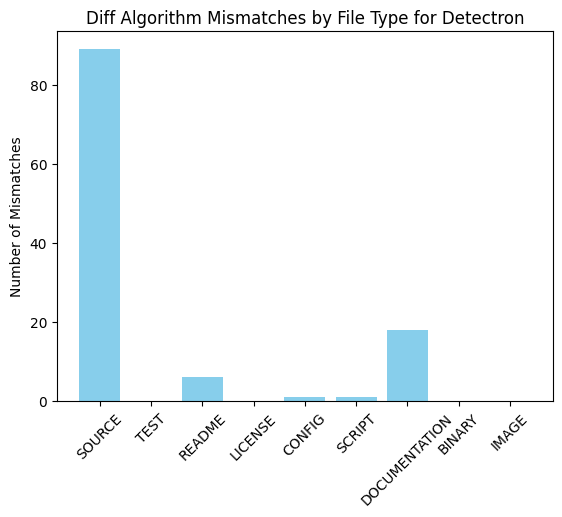

In [30]:
counts = [mismatch_counts1.get(cat, 0) for cat in ['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE']]
plt.bar(['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE'], counts, color='skyblue')
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=45)
plt.title("Diff Algorithm Mismatches by File Type for Detectron")
plt.show()

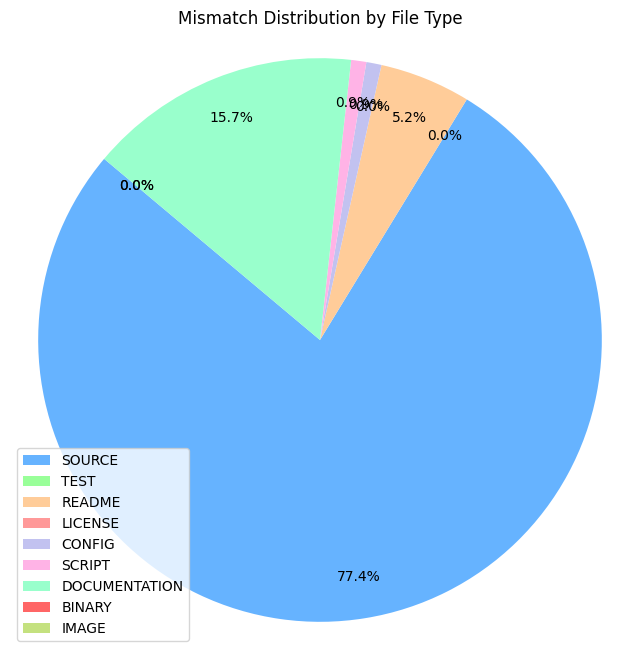

In [38]:
categories = ['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE']
counts = [mismatch_counts1.get(cat, 0) for cat in categories]
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999', '#c2c2f0', '#ffb3e6', '#99ffcc', '#ff6666', '#c4e17f']

plt.figure(figsize=(8,8))
plt.pie(
    counts, labels=None, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85
)
plt.legend(categories, loc='best')
plt.title("Mismatch Distribution by File Type")
plt.axis('equal')
plt.show()


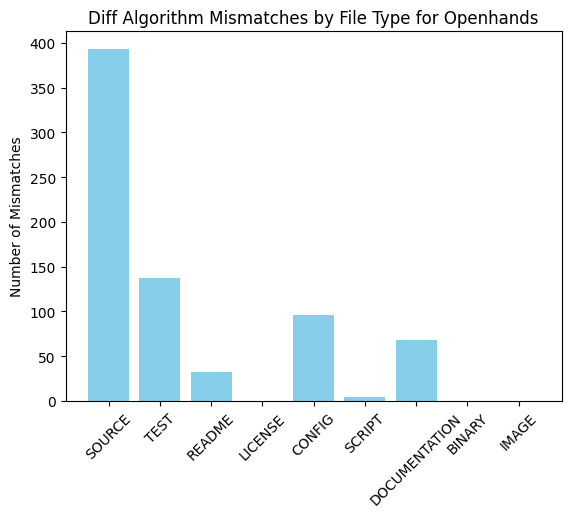

In [31]:
counts = [mismatch_counts2.get(cat, 0) for cat in ['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE']]
plt.bar(['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE'], counts, color='skyblue')
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=45)
plt.title("Diff Algorithm Mismatches by File Type for Openhands")
plt.show()

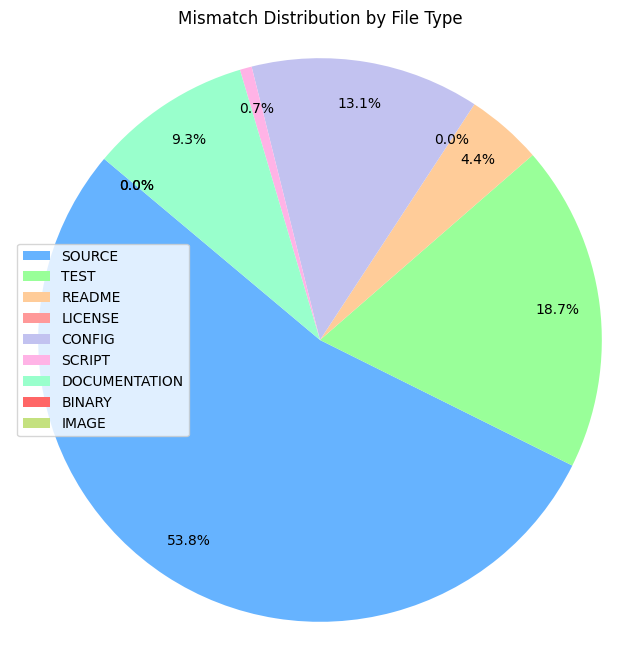

In [39]:
categories = ['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE']
counts = [mismatch_counts2.get(cat, 0) for cat in categories]
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999', '#c2c2f0', '#ffb3e6', '#99ffcc', '#ff6666', '#c4e17f']

plt.figure(figsize=(8,8))
plt.pie(
    counts, labels=None, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85
)
plt.legend(categories, loc='best')
plt.title("Mismatch Distribution by File Type")
plt.axis('equal')
plt.show()


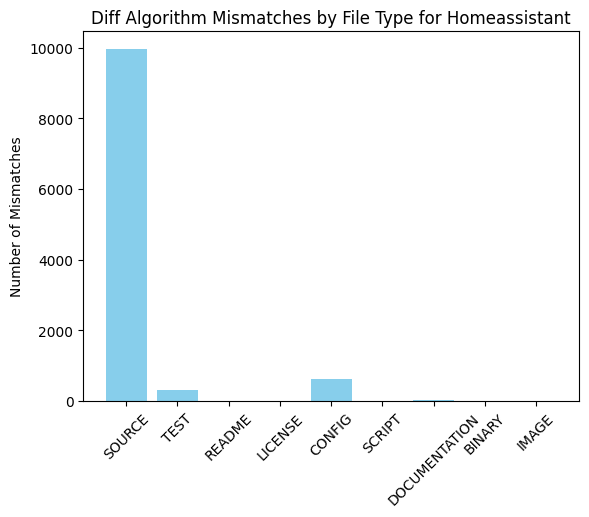

In [32]:
counts = [mismatch_counts3.get(cat, 0) for cat in ['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE']]
plt.bar(['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE'], counts, color='skyblue')
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=45)
plt.title("Diff Algorithm Mismatches by File Type for Homeassistant")
plt.show()

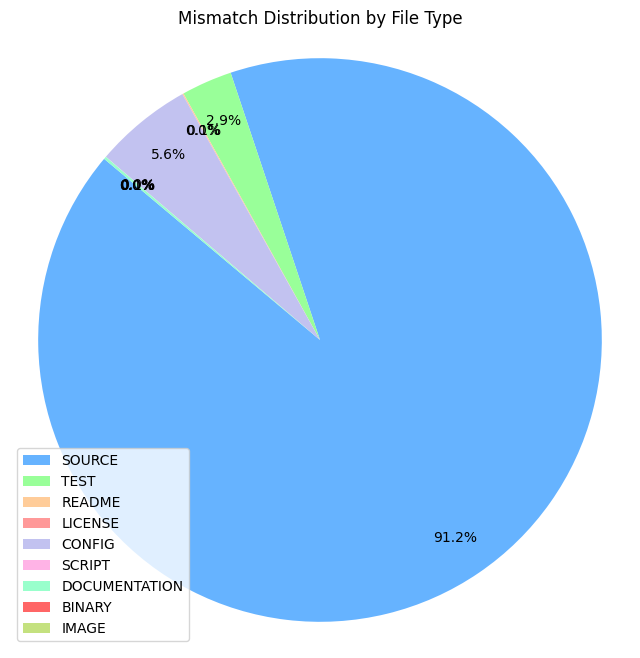

In [40]:
categories = ['SOURCE', 'TEST', 'README', 'LICENSE', 'CONFIG', 'SCRIPT', 'DOCUMENTATION', 'BINARY', 'IMAGE']
counts = [mismatch_counts3.get(cat, 0) for cat in categories]
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999', '#c2c2f0', '#ffb3e6', '#99ffcc', '#ff6666', '#c4e17f']

plt.figure(figsize=(8,8))
plt.pie(
    counts, labels=None, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85
)
plt.legend(categories, loc='best')
plt.title("Mismatch Distribution by File Type")
plt.axis('equal')
plt.show()
